In [29]:
import numpy as np
from pycpd import RigidRegistration
from pycpd import AffineRegistration
from pycpd import DeformableRegistration
from graspologic.align import SeedlessProcrustes
from sklearn.neighbors import NearestNeighbors

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import pickle
import random

import functions.xor_rxor_with_otp_functions as fn
from proglearn.sims import generate_gaussian_parity
from math import log2, ceil
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

In [125]:
#Function to rotate distribution
def rotate(X, theta=0, dim=[0,1]):
    #dimensions to rotate
    Z = X[:, dim]
    
    #rotation
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the X direction
def shearX(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, 0], [s, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the Y direction
def shearY(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, s], [0, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to double shear in the X direction
def double_shearX(X, y, ss=(0,0) , dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    i,j = dim
    t,b = ss
    
    Z_top = Z[Z[:,j] >= 0]
    Z_bot = Z[Z[:,j] < 0]
    c_top = y[Z[:,j] >= 0]
    c_bot = y[Z[:,j] < 0]
    
    #shear
    R_top = np.array([[1, 0], [t, 1]])
    R_bot = np.array([[1, 0], [b, 1]])
    Z_top = Z_top @ R_top
    Z_bot = Z_bot @ R_bot
    
    #recombine
    Z = np.concatenate((Z_top, Z_bot))
    y = np.concatenate((c_top, c_bot))
    X[:, dim] = Z
    
    return X, y

def shear_by_class(X, y, ss=(0,0), dim=[0,1]):
    X_0 = X[y == 0]
    X_1 = X[y == 1]
    X = np.concatenate((shearX(X_0, ss[0]), shearX(X_1, ss[1])))
    y = np.concatenate((np.zeros(X_0.shape[0]), np.ones(X_1.shape[0])))
    return X, y

def rotate_by_class(X, y, tt=(0,0), dim=[0,1]):
    X_0 = X[y == 0]
    X_1 = X[y == 1]
    X = np.concatenate((rotate(X_0, tt[0]), rotate(X_1, tt[1])))
    y = np.concatenate((np.zeros(X_0.shape[0]), np.ones(X_1.shape[0])))
    return X, y

def add_noise(X, y, sigma=0):
    noise = np.random.normal(0,sigma,X.shape)
    X = X + noise
    return X, y
    

def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

def cpd_reg(template, target, max_iter=200, tolerance=0.0001):    
    registration = AffineRegistration(X=target, Y=template, max_iterations=max_iter, tolerance=tolerance)
    deformed_template = registration.register(template)
    
    return deformed_template[0]

def nlr_reg(template, target, max_iter=200, tolerance=0.0001, alpha=2, beta=2):    
    registration = DeformableRegistration(X=target, Y=template, max_iterations=max_iter, tolerance=tolerance, alpha=alpha, beta=beta)
    deformed_template = registration.register(template)
    
    return deformed_template[0]

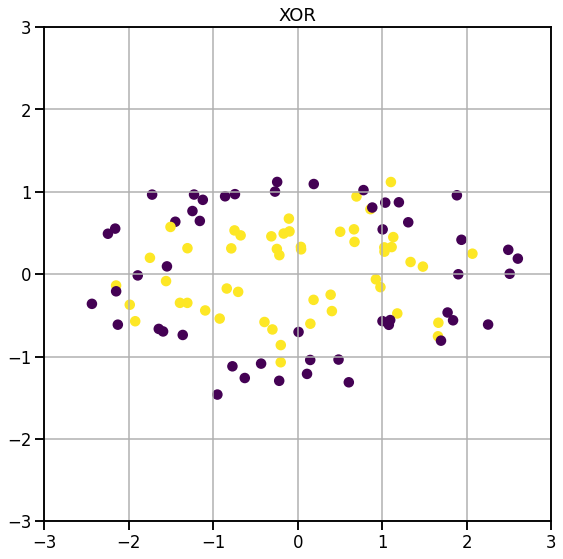

In [129]:
X, y = generate_rand_ellipse(100)
#X, y = shear_by_class(X, y, ss=(0,2))
#X, y = rotate_by_class(X, y, tt=(np.pi/3, np.pi))
X, y = add_noise(X, y, sigma=0.2)

plt.figure(figsize=(20,20));

plt.subplot(221);
plt.scatter(X[:,0], X[:,1], c=y);
plt.title("XOR");
plt.xlim([-3,3]); plt.ylim([-3,3]);
plt.grid();

In [11]:
def nearest_neighbor(src, dst, y_src, y_dst, class_aware=True):
    assert src.shape == dst.shape

    distances = np.zeros(y_src.shape)
    indices = np.zeros(y_src.shape, dtype=int)

    if class_aware:
        class1_src = np.where(y_src == 1)[0]
        class0_src = np.where(y_src == 0)[0]
        class1_dst = np.where(y_dst == 1)[0]
        class0_dst = np.where(y_dst == 0)[0]

        neigh_1 = NearestNeighbors(n_neighbors=1)
        neigh_1.fit(dst[class1_dst])
        distances_1, indices_1 = neigh_1.kneighbors(
            src[class1_src], return_distance=True
        )

        neigh_2 = NearestNeighbors(n_neighbors=1)
        neigh_2.fit(dst[class0_dst])
        distances_2, indices_2 = neigh_2.kneighbors(
            src[class0_src], return_distance=True
        )

        closest_class1 = class1_src[indices_1]
        closest_class0 = class0_src[indices_2]

        count = 0
        for i in class1_src:
            distances[i] = distances_1[count]
            indices[i] = closest_class1[count]
            count = count + 1

        count = 0
        for i in class0_src:
            distances[i] = distances_2[count]
            indices[i] = closest_class0[count]
            count = count + 1

    else:
        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(dst)
        distances, indices = neigh.kneighbors(src, return_distance=True)

    return distances.ravel(), indices.ravel()


def best_fit_transform(A, B):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m - 1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # homogeneous transformation
    T = np.identity(m + 1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def icp(A, B, y_src, y_dst, init_pose=None, max_iterations=500, tolerance=1e-26):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m + 1, A.shape[0]))
    dst = np.ones((m + 1, B.shape[0]))
    src[:m, :] = np.copy(A.T)
    dst[:m, :] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    imbalance = []

    class1_src = np.where(y_src == 1)[0]
    class0_src = np.where(y_src == 0)[0]
    class1_dst = np.where(y_dst == 1)[0]
    class0_dst = np.where(y_dst == 0)[0]

    imbalance.append(len(class1_src))
    imbalance.append(len(class0_src))
    imbalance.append(len(class1_dst))
    imbalance.append(len(class0_dst))

    mi = min(imbalance)

    X_1 = src[:, class1_src[0:mi]]
    X_2 = src[:, class0_src[0:mi]]

    src_subsample = np.concatenate((X_1, X_2), 1)
    y_src_sub = np.concatenate((np.ones(mi), np.zeros(mi)))

    X_1 = dst[:, class1_dst[0:mi]]
    X_2 = dst[:, class0_dst[0:mi]]
    dst_subsample = np.concatenate((X_1, X_2), 1)
    y_dst_sub = np.concatenate((np.ones(mi), np.zeros(mi)))

    for i in range(max_iterations):

        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(
            src_subsample[:m, :].T, dst_subsample[:m, :].T, y_src_sub, y_dst_sub
        )
        # distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T, y_src, y_dst)

        # compute the transformation between the current source and nearest destination points
        T, _, _ = best_fit_transform(
            src_subsample[:m, :].T, dst_subsample[:m, indices].T
        )
        # T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src_subsample = np.dot(T, src_subsample)
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    # T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, src, i

In [38]:
def get_random_pt(xlim_, ylim_):
    x = random.uniform(xlim_[0], xlim_[1])
    y = random.uniform(ylim_[0], ylim_[1])
    return x,y

def generate_rand_ellipse(n_sample):
    task_n_sample = n_sample / 2
    data = []
    label = []
    max_ite = 10000
    # make 2 elliptical rings defined by 3 ellipses
    # arbitrarily define the out-most one to be x^2/6^2 + y^2/3^2 = 1
    xlim_ = [-6,6]
    ylim_ = [-3,3]
    ite = 0
    # arbitrarily determine the width of the outer elliptical ring to be 1
    # then need to calculate the width of the inner ring in order to
    # keep the areas of the 2 rings to be the same
    # 5*2\pi - (6*3\pi - 5*2\pi) = 2\pi --> (5-x)(2-x) = 2
    width = np.roots([1,-7,8])[1]  # width of the inner ring
    # make sure there are the same number of data points in each ring/task
    while (label.count(0) < task_n_sample) or (label.count(1) < task_n_sample):
        if ite < max_ite:
            # use objection sampling: 
            # generate random points and only save one if it lies in predefined region
            x,y = get_random_pt(xlim_, ylim_)
            if label.count(0) < task_n_sample:
                # outer ring
                if (x**2 / 6**2 + y**2 / 3**2 < 1) & (x**2 / 5**2 + y**2 / 2**2 > 1):
                    data.append([x,y])
                    label.append(0)
            if label.count(1) < task_n_sample:
                # inner ring
                if (x**2 / (5-width)**2 + y**2 / (2-width)**2 > 1) & (x**2 / 5**2 + y**2 / 2**2 < 1):
                    data.append([x,y])
                    label.append(1)
            ite += 1
        else:
            break
    X = np.array(data)
    return (X-np.mean(X))/np.std(X), np.array(label)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

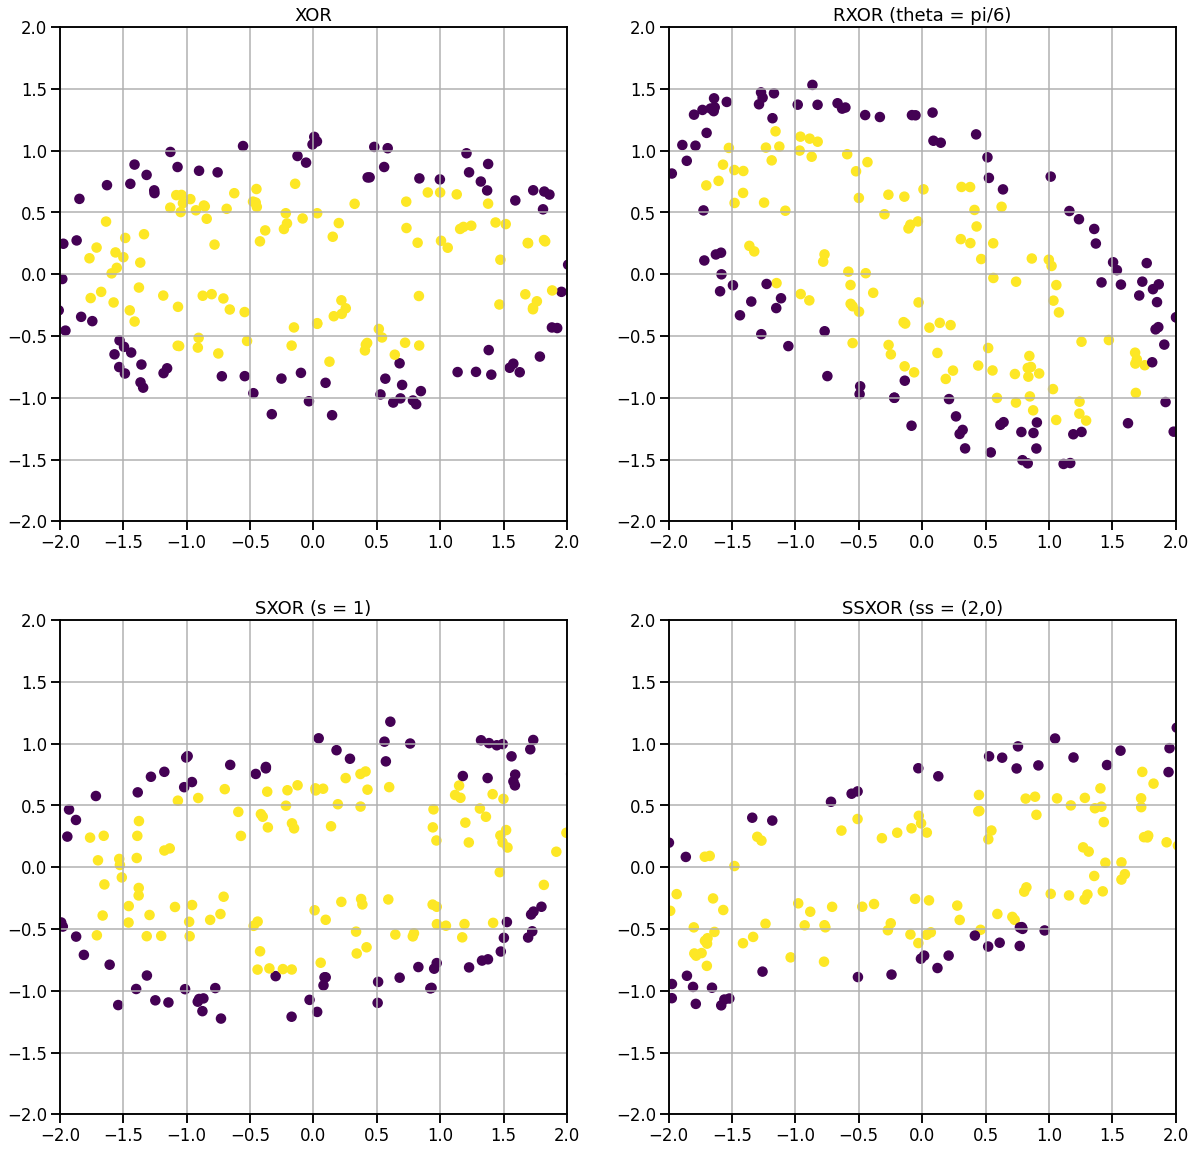

In [44]:
X1, y1 = generate_rand_ellipse(200)
X2, y2 = generate_rand_ellipse(200)
X3, y3 = generate_rand_ellipse(200)
X4, y4 = generate_rand_ellipse(200)


X2 = rotate(X2, theta=np.pi/6);
X3 = shearX(X3, s=0.5);
X4, y4 = double_shearX(X4, y4, ss=(2,2) , dim=[0,1])

plt.figure(figsize=(20,20));

plt.subplot(221);
plt.scatter(X1[:,0], X1[:,1], c=y1);
plt.title("XOR");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

plt.subplot(222);
plt.scatter(X2[:,0], X2[:,1], c=y2);
plt.title("RXOR (theta = pi/6)");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

plt.subplot(223);
plt.scatter(X3[:,0], X3[:,1], c=y3);
plt.title("SXOR (s = 1)");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

plt.subplot(224);
plt.scatter(X4[:,0], X4[:,1], c=y4);
plt.title("SSXOR (ss = (2,0)");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

In [6]:
def experiment(
    n_task1,
    n_task2,
    n_test=1000, 
    task1_angle=0,
    task2_shear=1, 
    n_trees=10,
    max_depth=None,
    random_state=None,
    register_cpd=False,
    register_otp=False,
    register_icp=False,
    register_nlr=False,
):

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    #classifier setup
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes": np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    naive_uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )

    #task 1 data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #task 2 data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task1_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
    #transform task 2
    X_task2 = shearX(X_task2, s=task2_shear)
    test_task2 = shearX(test_task2, s=task2_shear)
 
    if register_cpd:
        X_task1 = cpd_reg(X_task1.copy(), X_task2.copy())
    
    if register_icp:
        T, X_3, i = icp(X_task1.copy(), X_task2.copy(), y_task1.copy(), y_task2.copy())
        X_task1 = X_3.T[:, 0:2]
        
    if register_nlr:
        X_task1 = nlr_reg(X_task1.copy(), X_task2.copy())

    #train and predict
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2 * n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2 * n_trees)

    uf_task1 = uf.predict(test_task2, transformer_ids=[1], task_id=1)
    l2f_task1 = progressive_learner.predict(test_task2, task_id=1)

    errors[0] = 1 - np.mean(uf_task1 == test_label_task2)
    errors[1] = 1 - np.mean(l2f_task1 == test_label_task2)

    return errors

In [7]:
def fte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=False, register_otp=False, register_icp=False, register_nlr=False):
    mean_te = np.zeros(len(shear_sweep), dtype=float)
    gen_errors = []
    for ii, s in enumerate(shear_sweep):
        error = np.array(
            Parallel(n_jobs=-1, verbose=0)(
                delayed(experiment)(
                    task1_sample,
                    task2_sample,
                    task2_shear=s,
                    max_depth=ceil(log2(task1_sample)),
                    register_cpd=register_cpd,
                    register_otp=register_otp,
                    register_icp=register_icp,
                    register_nlr=register_nlr,
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        gen_errors.append((np.mean(error[:,0]), np.mean(error[:, 1])))

    return mean_te, gen_errors

In [12]:
#shear_sweep = np.arange(0,90,10)
shear_sweep = [x * 10**e for e in range(-2, 3) for x in [1, 2, 5]]
task1_sample = 100
task2_sample = 100
mc_rep = 250

In [13]:
shear_sweep

[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]

In [10]:
mean_te1, errors1 = fte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep)

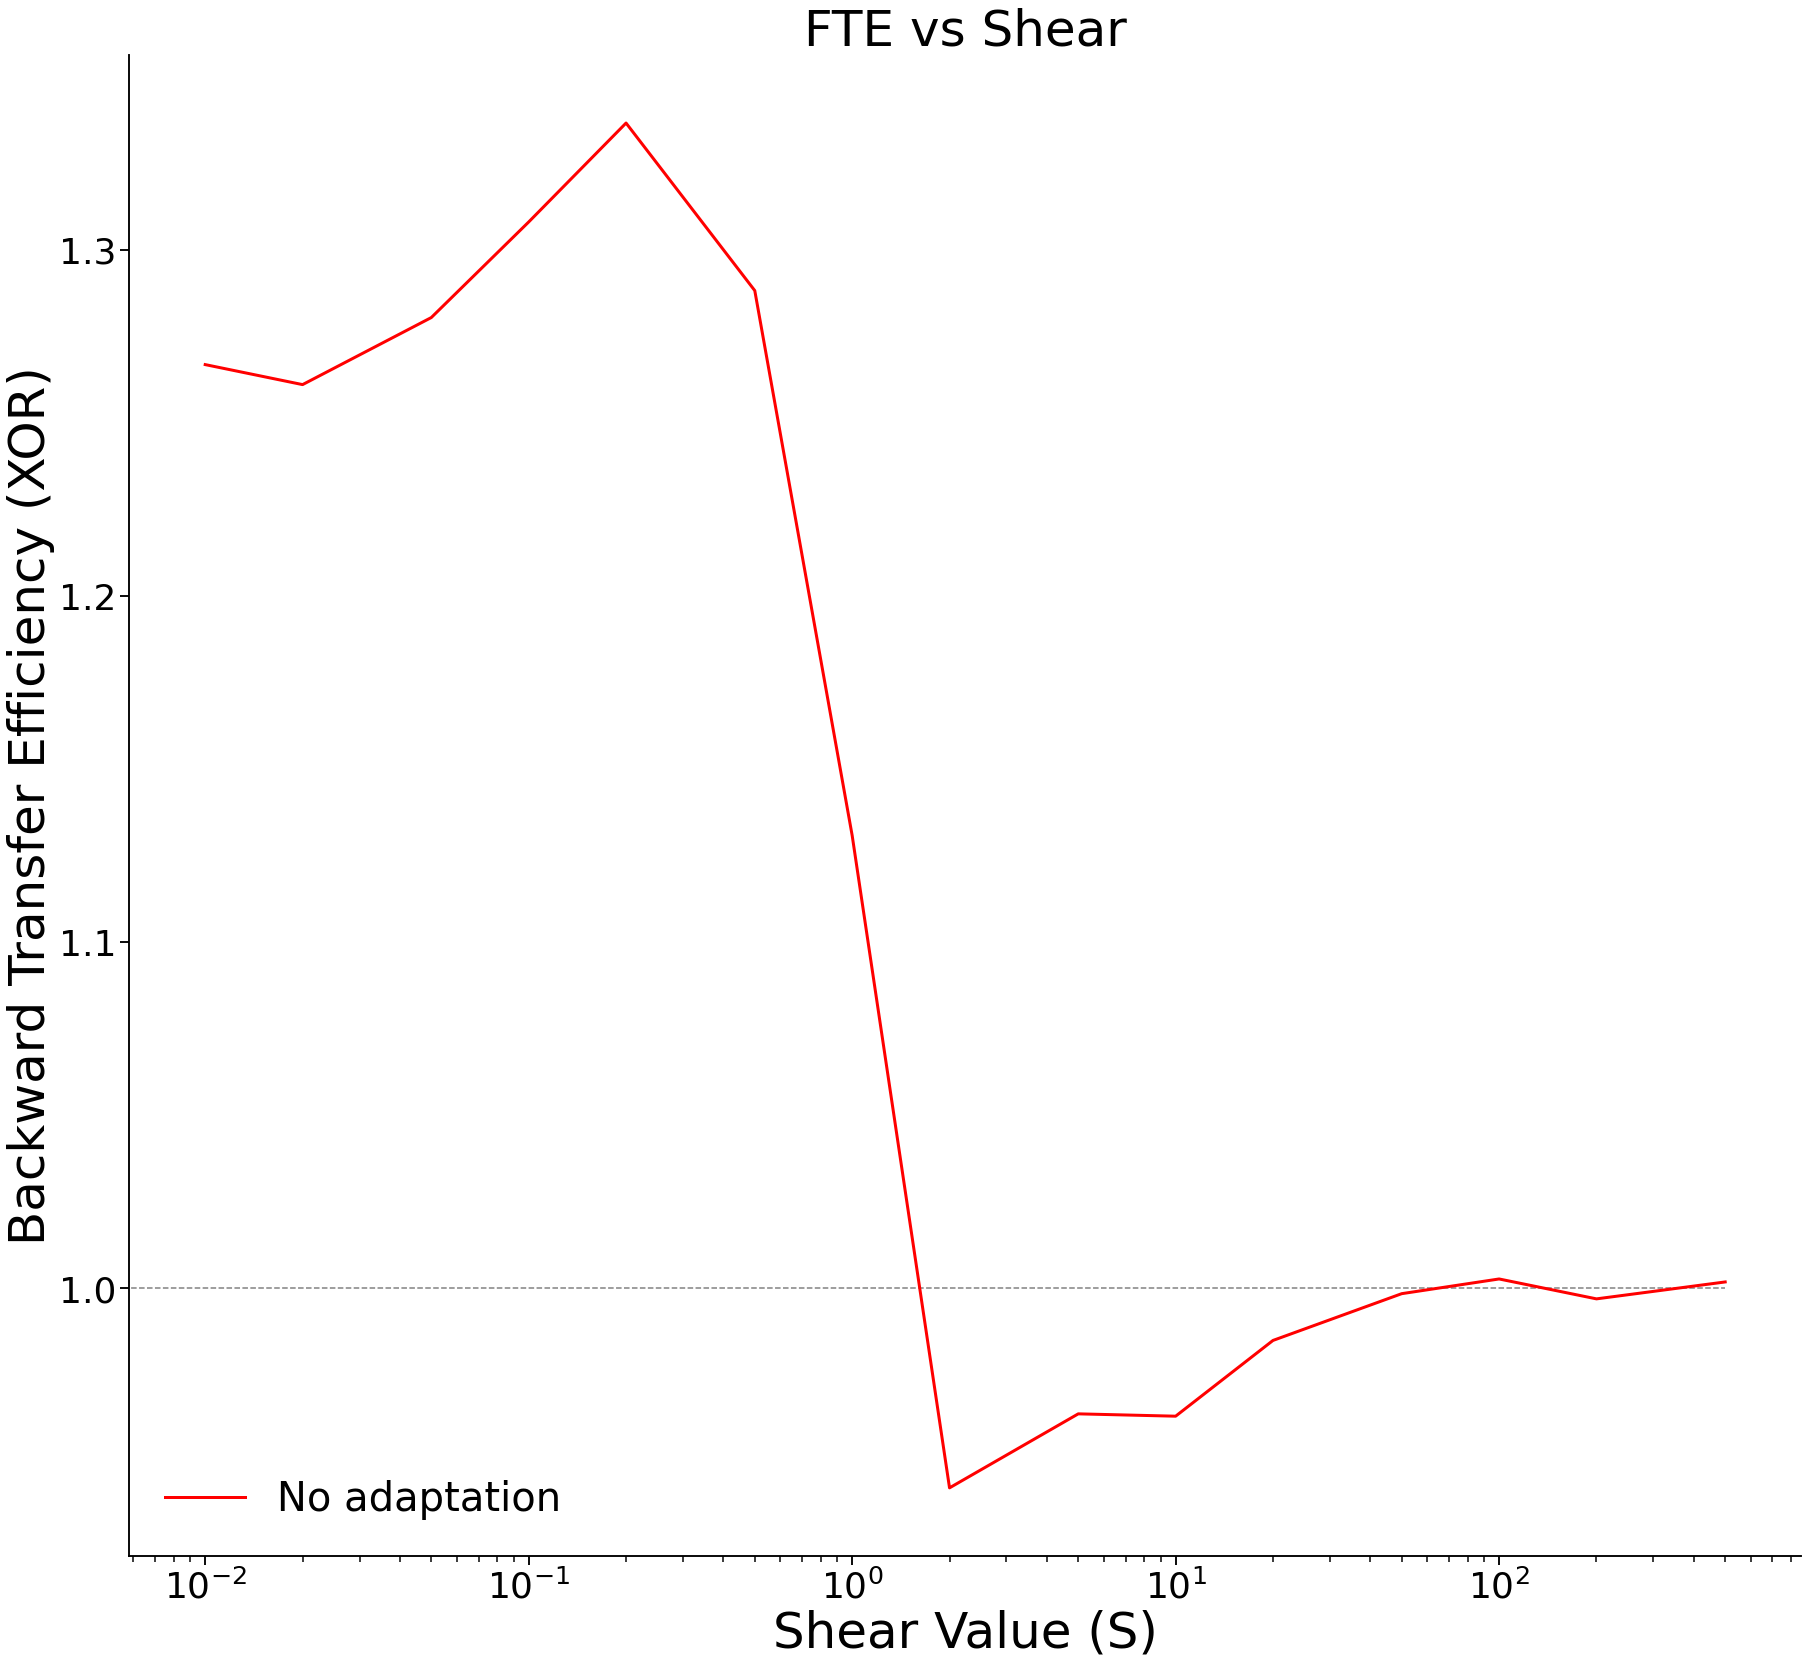

In [11]:
sns.set_context("talk")
fig = plt.figure(constrained_layout=True, figsize=(25, 23))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
task = ["No adaptation", "CPD", "ICP"]
ax.plot(shear_sweep, mean_te1, c="r", linewidth=3, label=task[0])
#ax.plot(shear_sweep, mean_te2, c="b", linewidth=3, label=task[1])
#ax.plot(shear_sweep, mean_te3, c="g", linewidth=3, label=task[2])
ax.set_xlabel("Shear Value (S)", fontsize=50)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=50)
ax.set_yticks([0.9, 1, 1.1, 1.2, 1.3])
ax.set_xscale('log')
ax.tick_params(labelsize=36)
ax.hlines(1, 0, 500, colors="grey", linestyles="dashed", linewidth=1.5)
ax.legend(loc="lower left", fontsize=40, frameon=False)
ax.set_title("FTE vs Shear", fontsize=50)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

file_to_save = 'affine_fte.pickle'
with open(file_to_save, 'wb') as f:
    pickle.dump(mean_te1, f)

In [12]:
mean_te2, errors2 = fte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)

In [13]:
mean_te3, errors3 = fte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

In [14]:
#mean_te3 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_otp=True)

In [15]:
mean_te4, errors4 = fte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)

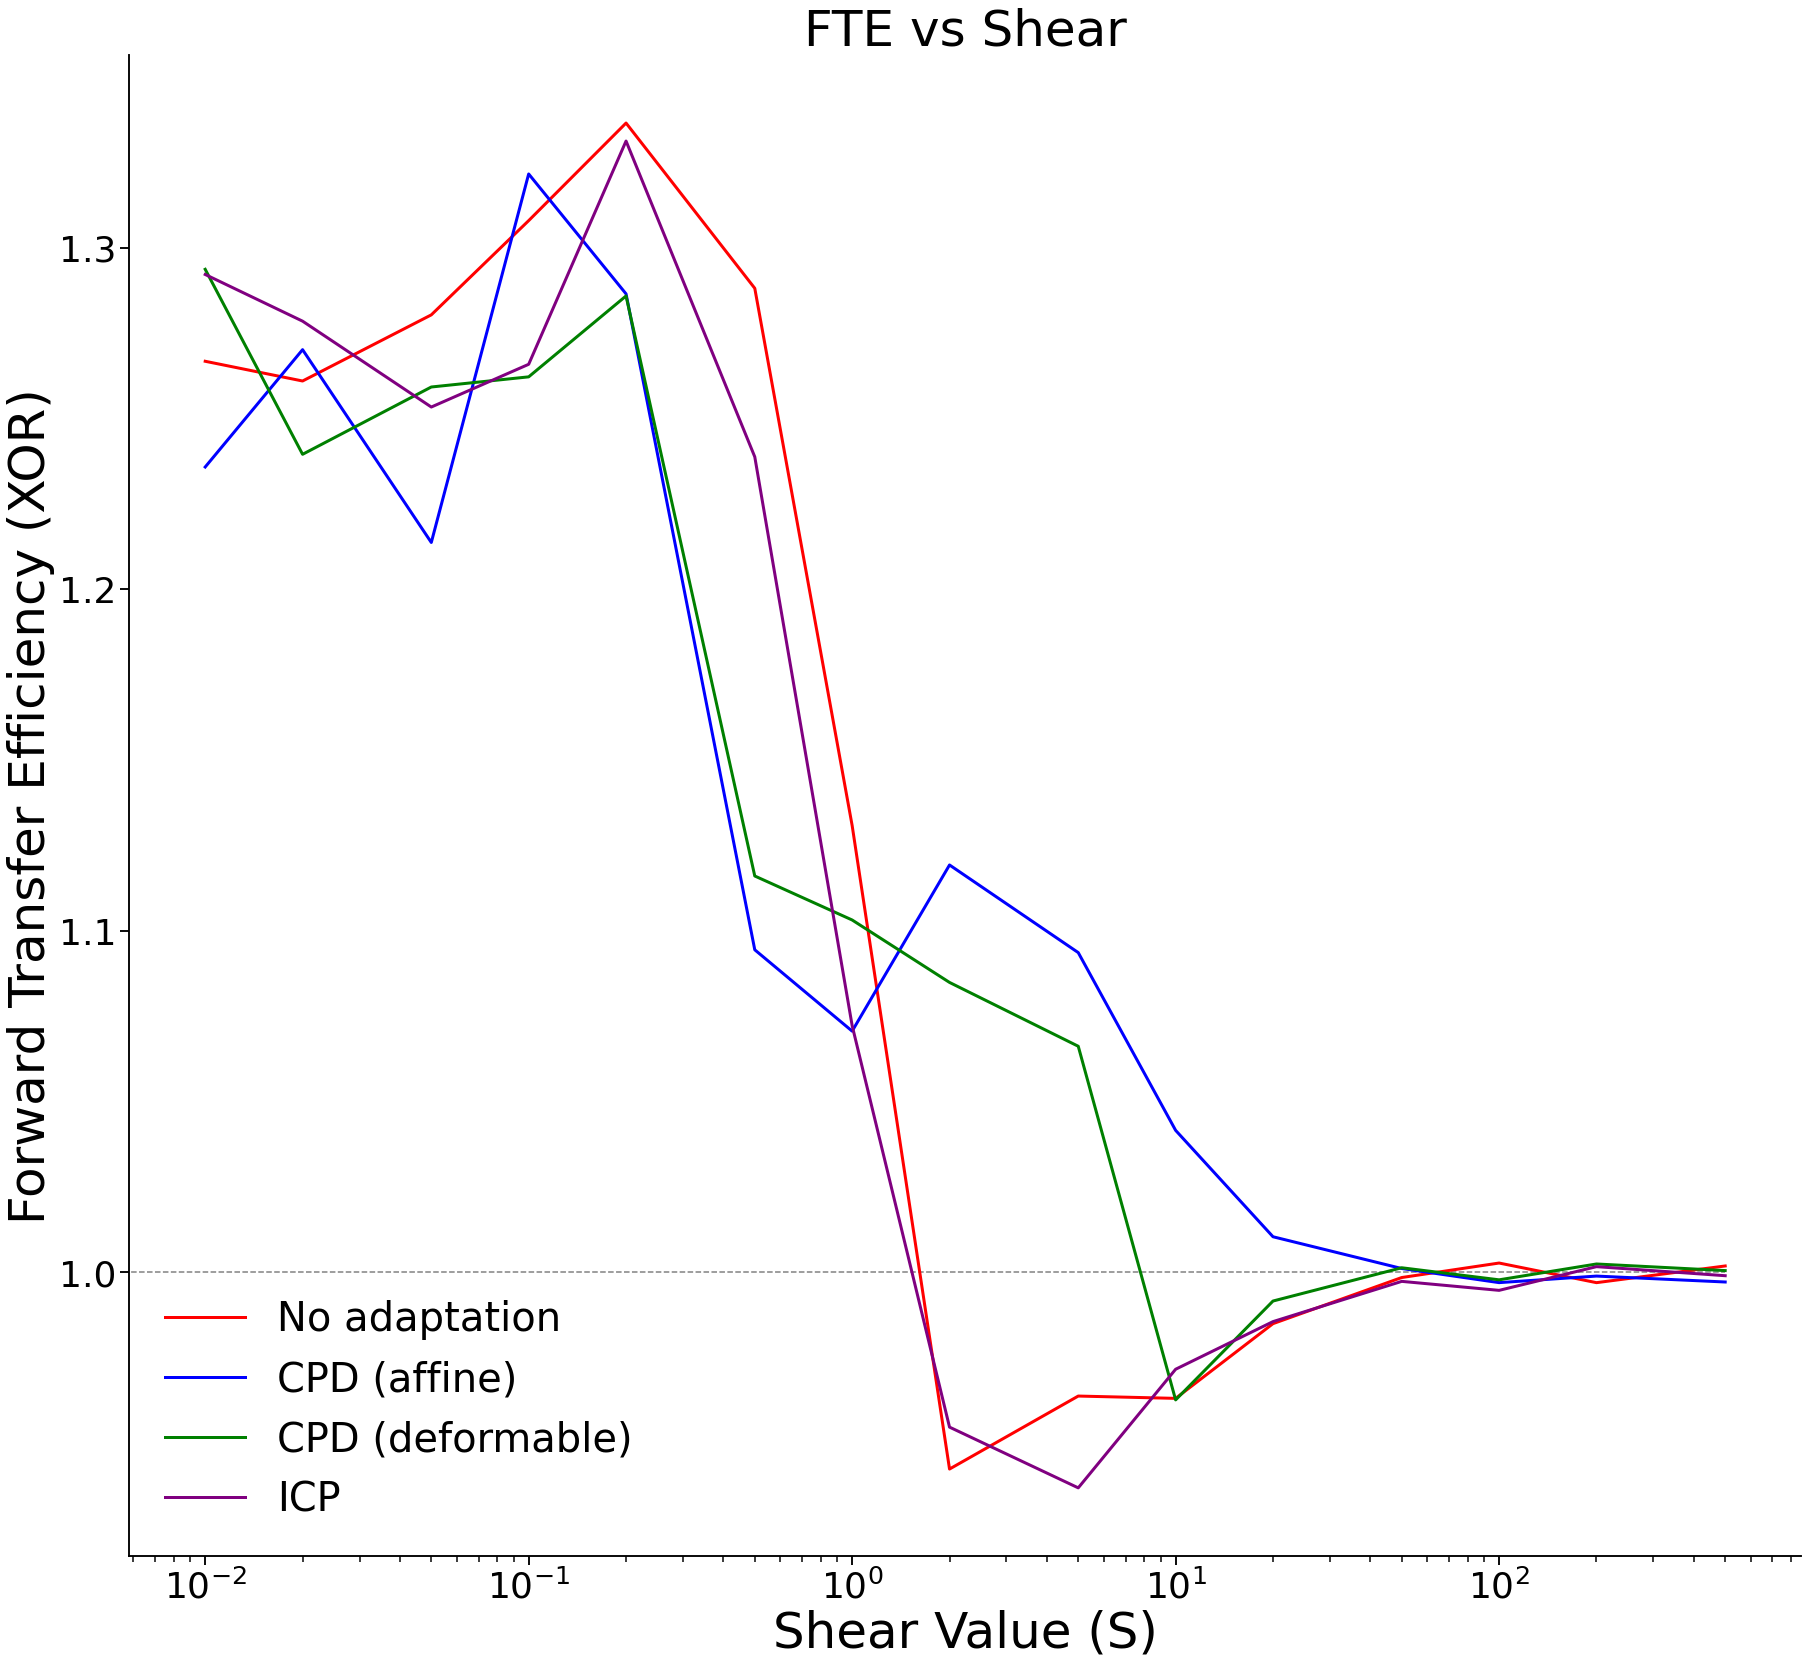

In [16]:
sns.set_context("talk")
fig = plt.figure(constrained_layout=True, figsize=(25, 23))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
task = ["No adaptation", "CPD (affine)", "CPD (deformable)", "ICP"]
ax.plot(shear_sweep, mean_te1, c="r", linewidth=3, label=task[0])
ax.plot(shear_sweep, mean_te2, c="b", linewidth=3, label=task[1])
ax.plot(shear_sweep, mean_te3, c="g", linewidth=3, label=task[2])
ax.plot(shear_sweep, mean_te4, c="purple", linewidth=3, label=task[3])
ax.set_xlabel("Shear Value (S)", fontsize=50)
ax.set_ylabel("Forward Transfer Efficiency (XOR)", fontsize=50)
ax.set_yticks([0.9, 1, 1.1, 1.2, 1.3])
ax.set_xscale('log')
ax.tick_params(labelsize=36)
ax.hlines(1, 0, 500, colors="grey", linestyles="dashed", linewidth=1.5)
ax.legend(loc="lower left", fontsize=40, frameon=False)
ax.set_title("FTE vs Shear", fontsize=50)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

file_to_save = 'affine_fte_cpd_aff.pickle'
with open(file_to_save, 'wb') as f:
    pickle.dump(mean_te2, f)
    
file_to_save = 'affine_fte_cpd_nlr.pickle'
with open(file_to_save, 'wb') as f:
    pickle.dump(mean_te3, f)

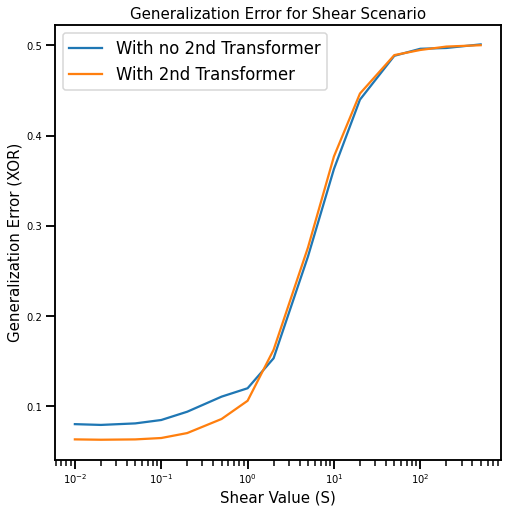

In [19]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(shear_sweep, np.array(errors1)[:,0])
ax.plot(shear_sweep, np.array(errors1)[:,1])
ax.set_xscale('log')
ax.tick_params(labelsize=10)
ax.set_title("Generalization Error for Shear Scenario", fontsize=15)
ax.set_xlabel("Shear Value (S)", fontsize=15)
ax.set_ylabel("Generalization Error (XOR)", fontsize=15)
#ax.set_yticks(np.arange(0.1, 0.41, 0.05))
ax.legend(['With no 2nd Transformer', 'With 2nd Transformer'])

In [14]:
def experiment2(
    n_task1,
    n_task2,
    n_test=1000, 
    task1_angle=0,
    task2_shear=1, 
    n_trees=10,
    max_depth=None,
    random_state=None,
    register_cpd=False,
    register_nlr=False,
    register_otp=False,
    register_icp=False,
):

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    #classifier setup
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes": np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    naive_uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )

    #task 1 data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #task 2 data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task1_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
    #transform task 2
    X_task2, y_task2 = double_shearX(X_task2, y_task2, ss=(task2_shear, -task2_shear));
    test_task2, test_label_task2 = double_shearX(test_task2, test_label_task2, ss=(task2_shear, -task2_shear));
 
    if register_cpd:
        #X_task1 = cpd_reg(X_task1.copy(), X_task2.copy(), tolerance=1e-8)
        X_task2 = cpd_reg(X_task2.copy(), X_task1.copy(), tolerance=1e-8)
        
    if register_nlr:
        #X_task1 = nlr_reg(X_task1.copy(), X_task2.copy(), tolerance=1e-8, alpha=0.001, beta=1)
        X_task2 = nlr_reg(X_task2.copy(), X_task1.copy(), tolerance=1e-8, alpha=0.001, beta=1)
    
    if register_icp:
        #T, X_3, i = icp(X_task1.copy(), X_task2.copy(), y_task1.copy(), y_task2.copy())
        #X_task1 = X_3.T[:, 0:2]
        T, X_3, i = icp(X_task2.copy(), X_task1.copy(), y_task2.copy(), y_task1.copy())
        X_task2 = X_3.T[:, 0:2]

    #train and predict
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2 * n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2 * n_trees)

    #uf_task2 = uf.predict(test_task2, transformer_ids=[1], task_id=1)
    #l2f_task2 = progressive_learner.predict(test_task2, task_id=1)
    
    uf_task1 = uf.predict(test_task1, transformer_ids=[0], task_id=0)
    l2f_task1 = progressive_learner.predict(test_task1, task_id=0)

    #errors[0] = 1 - np.mean(uf_task2 == test_label_task2)
    #errors[1] = 1 - np.mean(l2f_task2 == test_label_task2)
    
    errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
    errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)

    return errors

In [15]:
def fte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=False, register_nlr=False, register_otp=False, register_icp=False):
    mean_te = np.zeros(len(shear_sweep), dtype=float)
    for ii, s in enumerate(shear_sweep):
        error = np.array(
            Parallel(n_jobs=-1, verbose=0)(
                delayed(experiment2)(
                    task1_sample,
                    task2_sample,
                    task2_shear=s,
                    max_depth=ceil(log2(task1_sample)),
                    register_cpd=register_cpd,
                    register_nlr=register_nlr,
                    register_otp=register_otp,
                    register_icp=register_icp
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

    return mean_te

In [16]:
#main hyperparameters
shear_sweep = [x * 10**e for e in range(-2, 3) for x in [1, 2, 5]];
task1_sample = 100
task2_sample = 100
mc_rep = 250

In [17]:
mean_te1 = fte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep)

In [20]:
mean_te2 = fte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)

In [21]:
mean_te3 = fte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)

In [22]:
mean_te4 = fte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

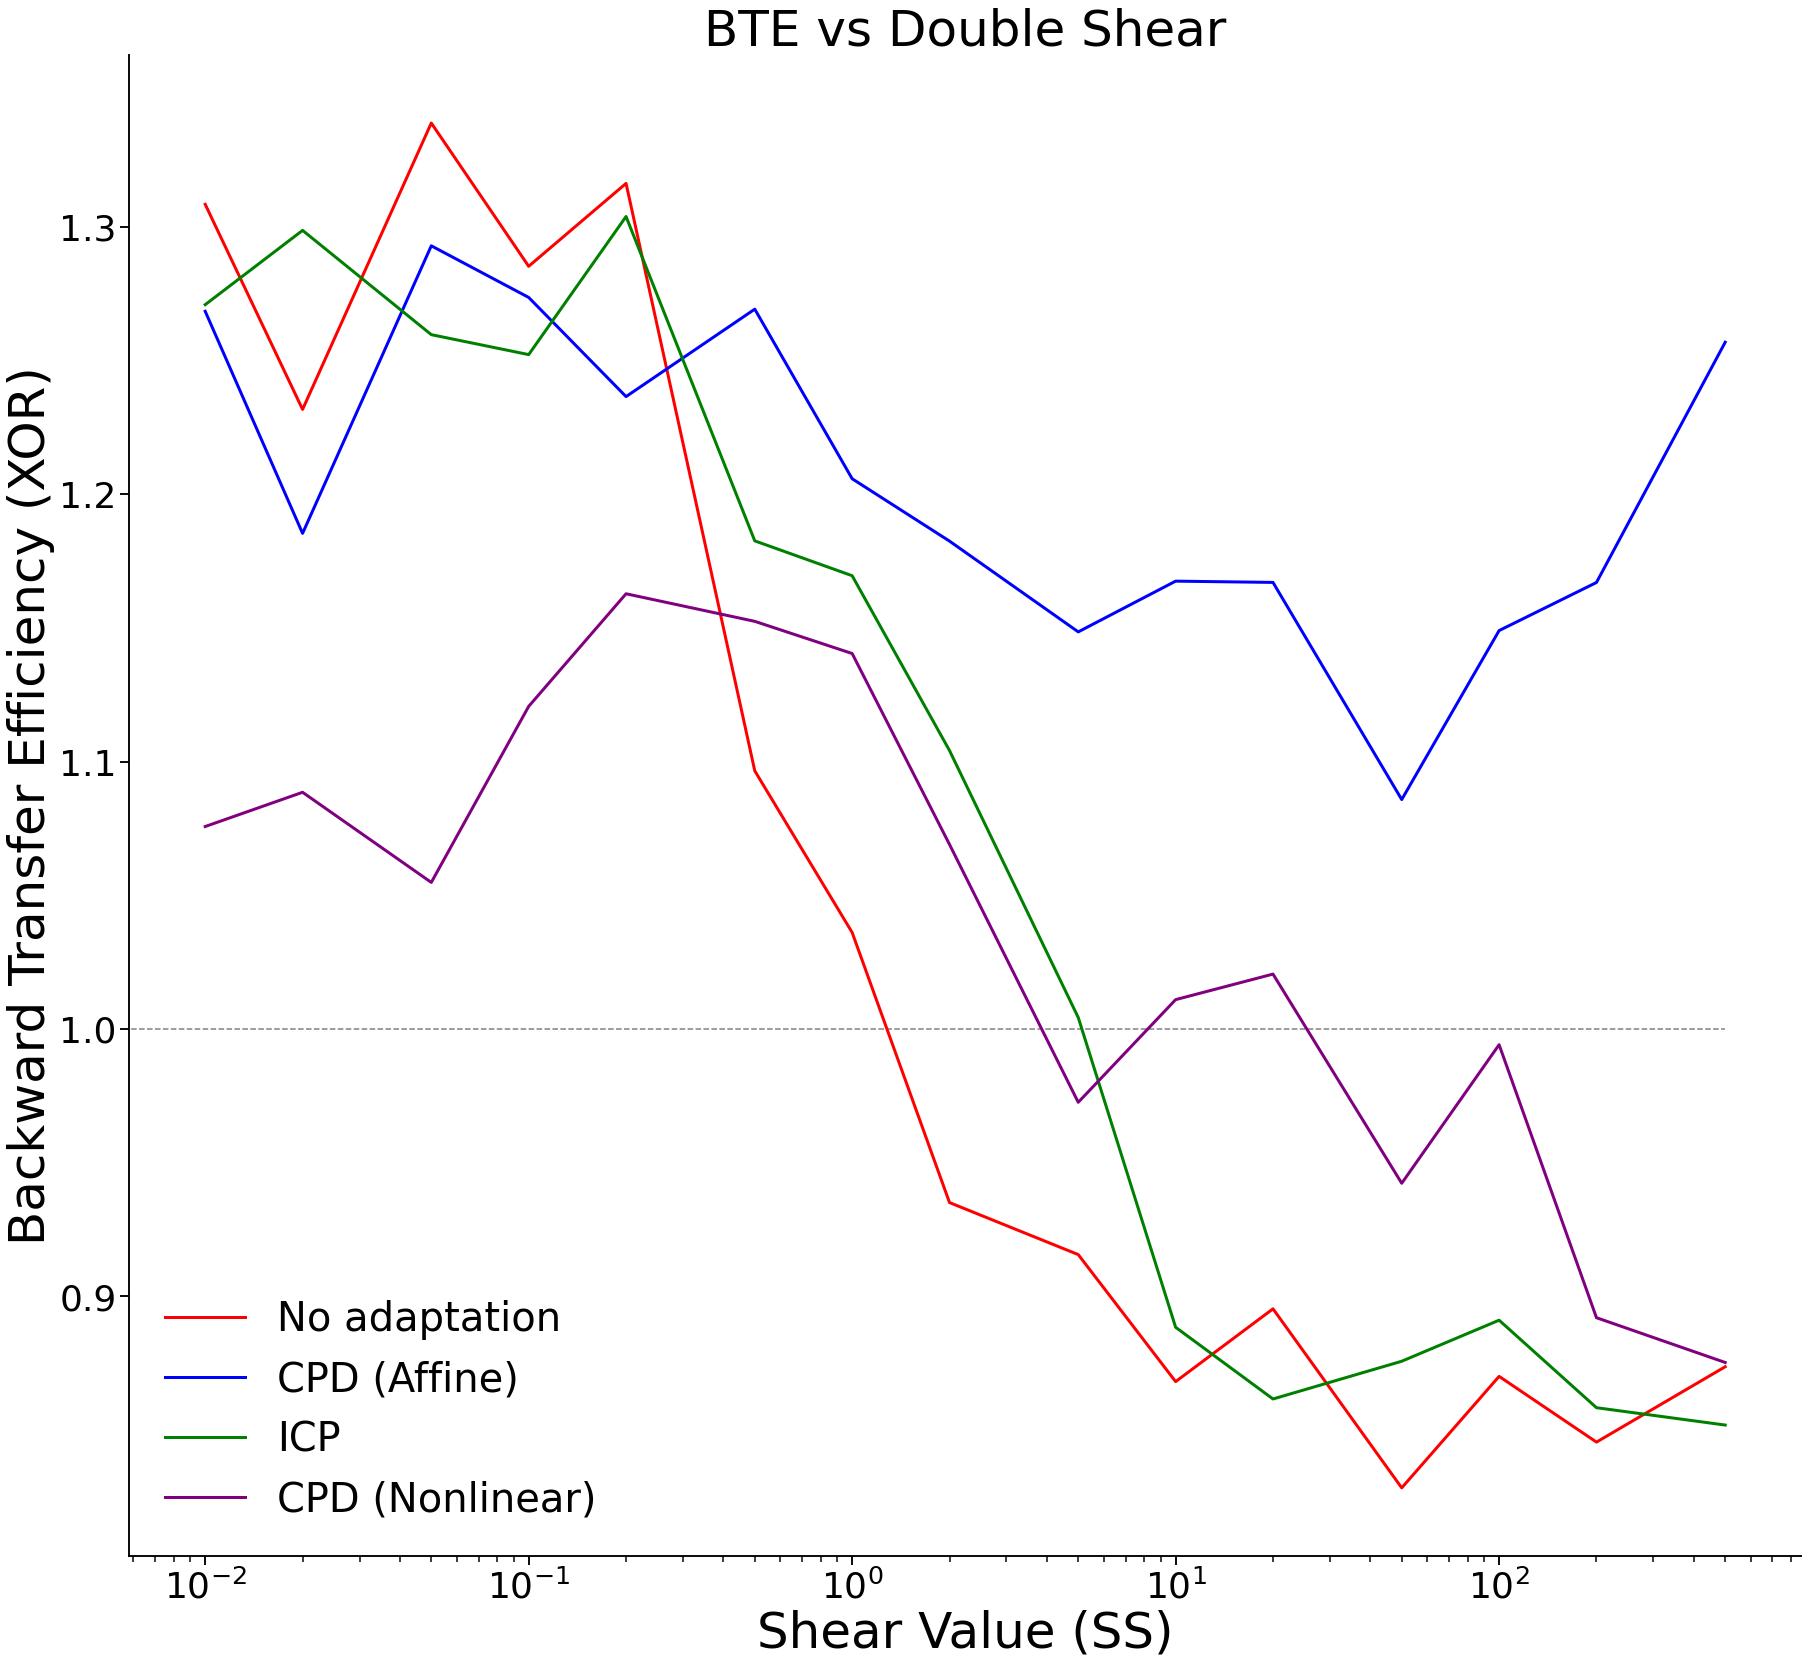

In [23]:
sns.set_context("talk")
fig = plt.figure(constrained_layout=True, figsize=(25, 23))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
task = ["No adaptation", "CPD (Affine)", "ICP", "CPD (Nonlinear)"]
ax.plot(shear_sweep, mean_te1, c="r", linewidth=3, label=task[0])
ax.plot(shear_sweep, mean_te2, c="b", linewidth=3, label=task[1])
ax.plot(shear_sweep, mean_te3, c="g", linewidth=3, label=task[2])
ax.plot(shear_sweep, mean_te4, c="purple", linewidth=3, label=task[3])
ax.set_xlabel("Shear Value (SS)", fontsize=50)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=50)
ax.set_yticks([0.9, 1, 1.1, 1.2, 1.3])
ax.set_xscale('log')
ax.tick_params(labelsize=36)
ax.hlines(1, 0, 500, colors="grey", linestyles="dashed", linewidth=1.5)
ax.legend(loc="lower left", fontsize=40, frameon=False)
ax.set_title("BTE vs Double Shear", fontsize=50)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

In [ ]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(shear_sweep, np.array(errors1)[:,0])
ax.plot(shear_sweep, np.array(errors1)[:,1])
ax.set_xscale('log')
ax.tick_params(labelsize=10)
ax.set_title("Generalization Error for Shear Scenario", fontsize=15)
ax.set_xlabel("Shear Value (S)", fontsize=15)
ax.set_ylabel("Generalization Error (XOR)", fontsize=15)
#ax.set_yticks(np.arange(0.1, 0.41, 0.05))
ax.legend(['With no 2nd Transformer', 'With 2nd Transformer'])

## Visualizing transformations for BTE 

In [ ]:
#distribution generation
X = [];
y = [];

S = [0.1, 1, 2, 5, 10];

for i in S:
    D,c = generate_gaussian_parity(100);
    D = shearX(D, s=i);
    
    X.append(D);
    y.append(c);

#Original XOR
U,v = generate_gaussian_parity(100);


In [ ]:
#Plot Transformation
l = 2;
w = 3;
n = len(S)
plt.figure(figsize=(w*8, n*8))

plt.subplot(n,w,1);
plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
plt.xlim([-l,l]); plt.ylim([-l,l]);
plt.grid(); plt.title('XOR');

for i in range(n):
    #Task 2 Distribution
    x = X[i];
    z = cpd_reg(x, U, max_iter=200, tolerance=0.0001)
    
    plt.subplot(n,w, w*i+2);
    plt.scatter(z[:,0], z[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Adapted SXOR');
    
    plt.subplot(n,w, w*i+3);
    plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('SXOR (s={})'.format(S[i]));

## Visualizing Transformations for FTE

In [ ]:
#distribution generation
X = [];
y = [];

S = [0.1, 1, 2, 5, 10];

for i in S:
    D,c = generate_gaussian_parity(100);
    D = shearX(D, s=i);
    
    X.append(D);
    y.append(c);

#Original XOR
U,v = generate_gaussian_parity(100);

In [ ]:
#Plot Transformation
l = 2;
w = 3;
n = len(S)
plt.figure(figsize=(w*8, n*8))

plt.subplot(n,w,1);
plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
plt.xlim([-l,l]); plt.ylim([-l,l]);
plt.grid(); plt.title('XOR');

for i in range(n):
    #Task 2 Distribution
    x = X[i];
    z = cpd_reg(U, x, max_iter=200, tolerance=0.0001)
    
    plt.subplot(n,w, w*i+2);
    plt.scatter(z[:,0], z[:,1], c=v, cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Adapted SXOR');
    
    plt.subplot(n,w, w*i+3);
    plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('SXOR (s={})'.format(S[i]));

In [ ]:
#Plot Transformation
l = 2;
w = 3;
n = len(S)
plt.figure(figsize=(w*8, n*8))

plt.subplot(n,w,1);
plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
plt.xlim([-l,l]); plt.ylim([-l,l]);
plt.grid(); plt.title('XOR');

for i in range(n):
    #Task 2 Distribution
    x = X[i];
    z = cpd_reg(U, x, max_iter=200, tolerance=0.0001)
    
    plt.subplot(n,w, w*i+2);
    plt.scatter(z[:,0], z[:,1], c=v, cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Adapted SXOR');
    
    plt.subplot(n,w, w*i+3);
    plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('SXOR (s={})'.format(S[i]));

In [45]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

#Grid Setup
l = 3
h = 0.05 
xx, yy = np.meshgrid(np.arange(-l, l, h), np.arange(-l, l, h))
grid = np.c_[xx.ravel(), yy.ravel()]

In [157]:
#distribution generation
X = [];
y = [];

S = [1, 2, 5, 10];
#S = [np.pi/6, np.pi/4, np.pi/3, np.pi/2]
#S = [0.1, 0.2, 0.5, 1];

for i in S:
    #D,c = generate_gaussian_parity(100);
    D,c = generate_rand_ellipse(100)
    D,c = double_shearX(D,c, ss=(i,-i));
    #D,c = shear_by_class(D,c, ss=(i,-i));
    #D,c = rotate_by_class(D,c, tt=(0,i));
    #D,c = rotate_by_class(D,c, tt=(i,-i));
    #D,c = add_noise(D,c, sigma=i);
    
    X.append(D);
    y.append(c);

#Original XOR
#U,v = generate_gaussian_parity(100);
U,v = generate_rand_ellipse(100)

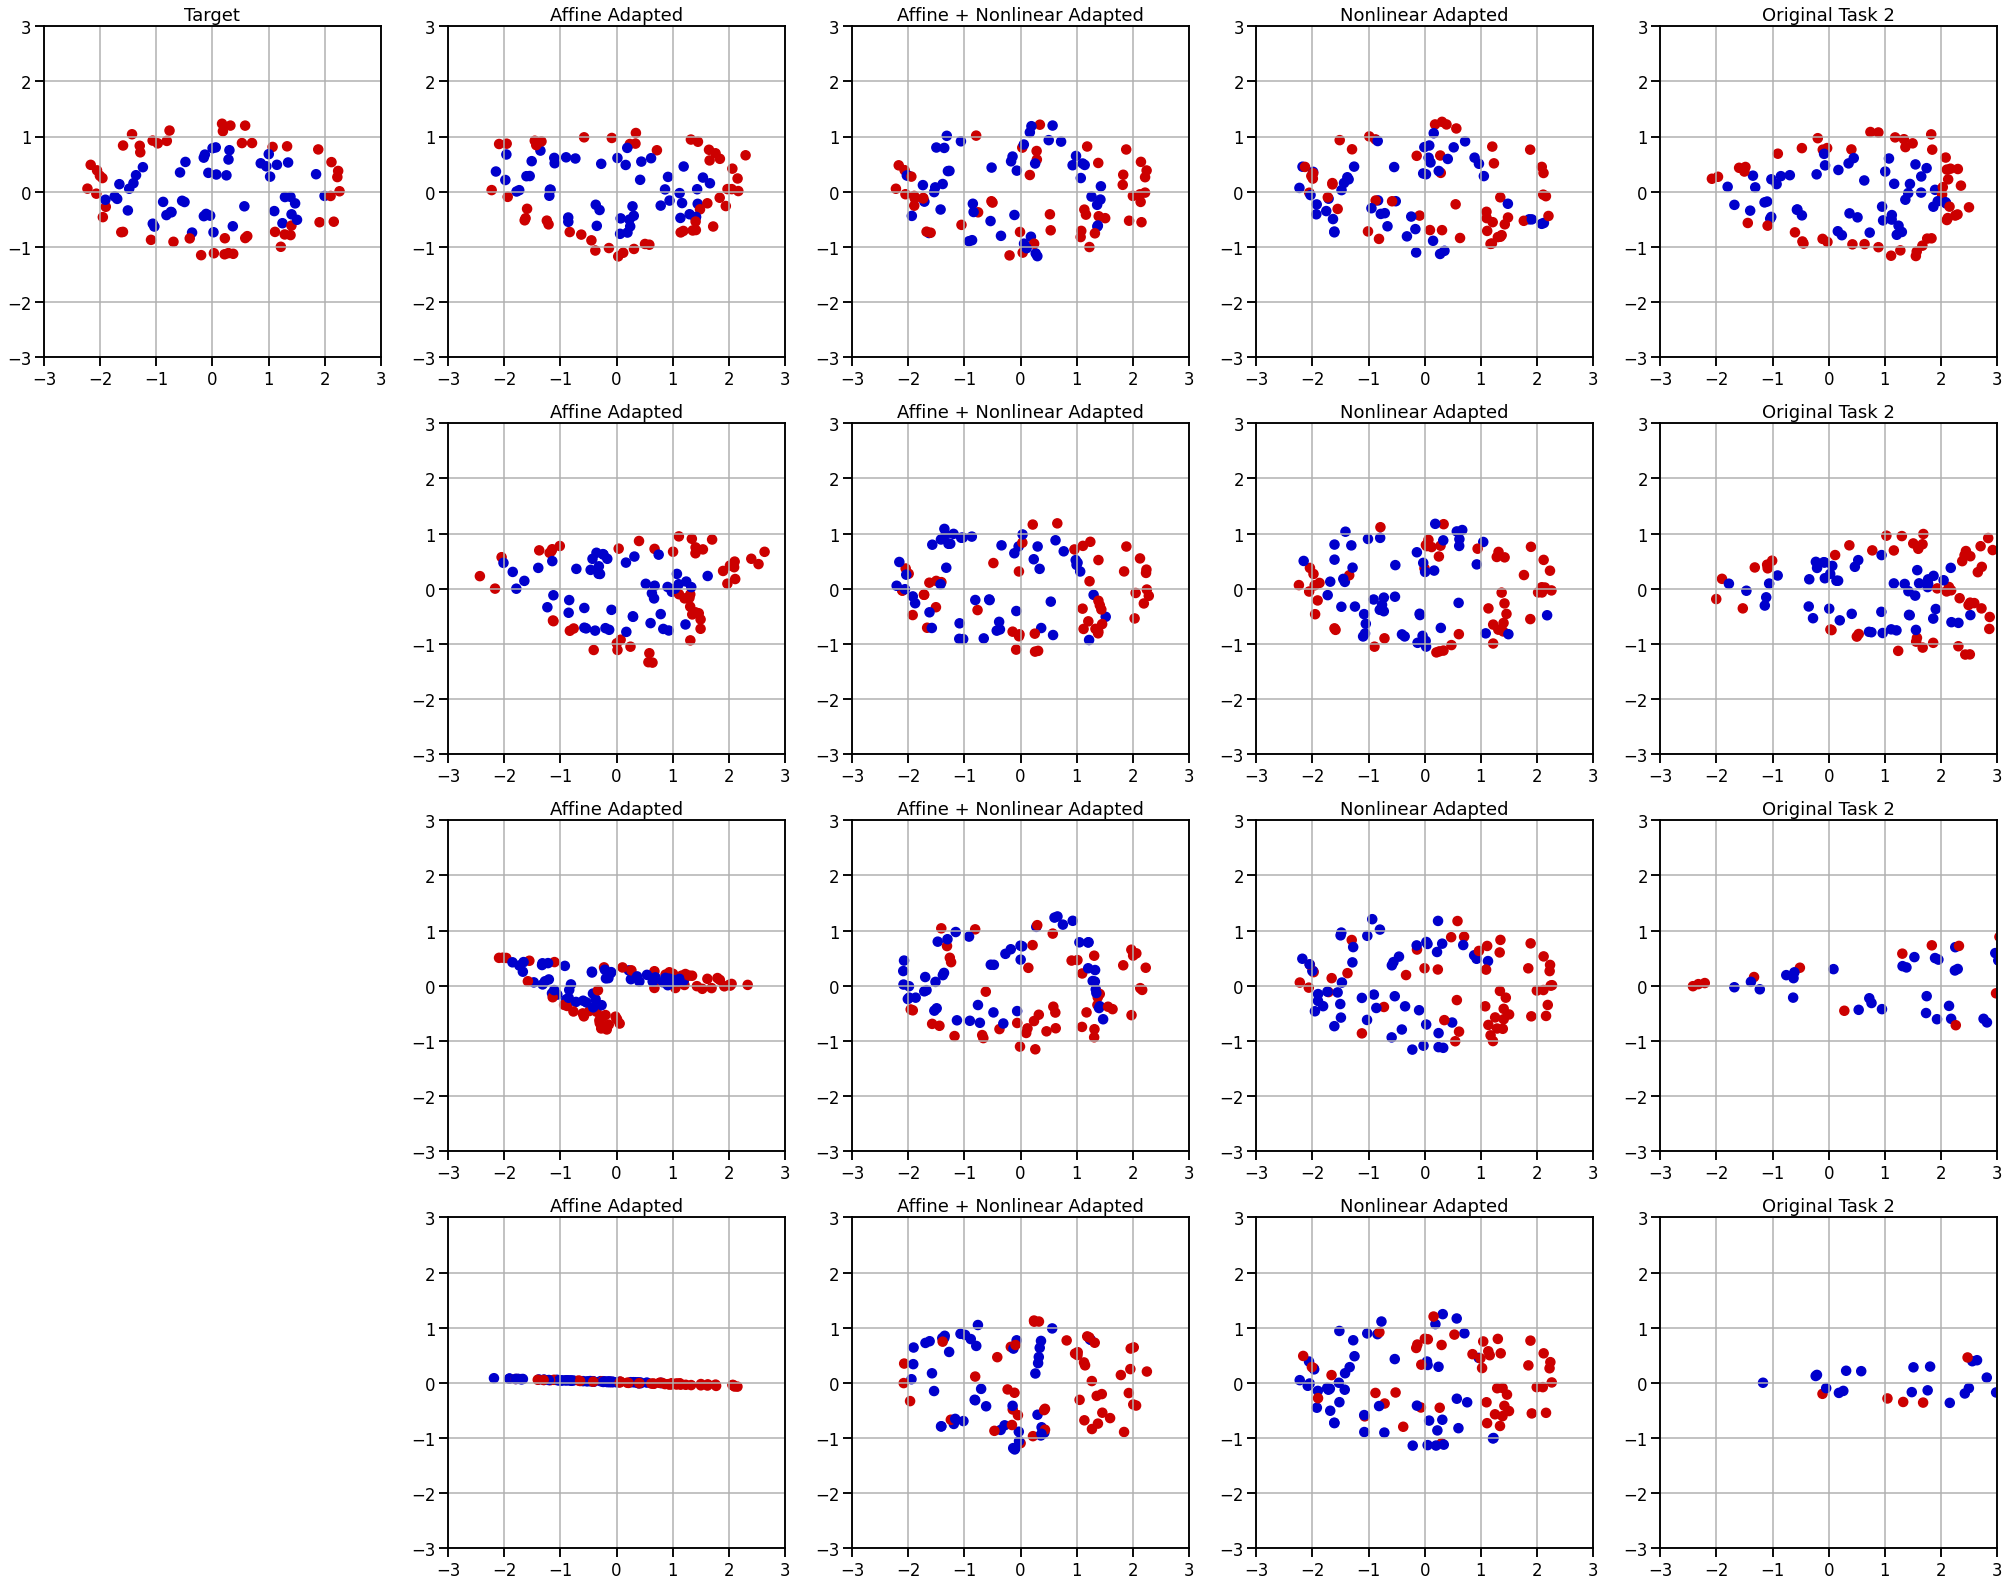

In [158]:
#Plot Transformation
l = 3;
w = 5;
n = len(S)
plt.figure(figsize=(w*7, n*7))

cap = 200

plt.subplot(n,w,1);
plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
plt.xlim([-l,l]); plt.ylim([-l,l]);
plt.grid(); plt.title('Target');

for i in range(n):
    #Task 2 Distribution
    x = X[i];
    a = cpd_reg(x, U, max_iter=cap)
    b = nlr_reg(x, U, max_iter=cap, tolerance=1e-8, alpha=0.001, beta=1)
    c = nlr_reg(a, U, max_iter=cap, tolerance=1e-8, alpha=0.001, beta=1)
    
    plt.subplot(n,w, w*i+2);
    plt.scatter(a[:,0], a[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Affine Adapted');
    
    plt.subplot(n,w, w*i+3);
    plt.scatter(c[:,0], c[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Affine + Nonlinear Adapted');
    
    plt.subplot(n,w, w*i+4);
    plt.scatter(b[:,0], b[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Nonlinear Adapted');
    
    plt.subplot(n,w, w*i+5);
    plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    #plt.grid(); plt.title('SSXOR (ss=({},-{})'.format(S[i],S[i]));
    plt.grid(); plt.title('Original Task 2');

In [159]:
#Prarameters
n_trees=10
max_depth=None

c_afn = [];
p_afn = [];
x_afn = [];

c_nlr = [];
p_nlr = [];
x_nlr = [];

for i in range(len(S)):
    #Model
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class = default_transformer_class,
        default_transformer_kwargs = default_transformer_kwargs,
        default_voter_class = default_voter_class,
        default_voter_kwargs = default_voter_kwargs,
        default_decider_class = default_decider_class,
        default_decider_kwargs = default_decider_kwargs)

    #Adaptation
    #x = cpd_reg(X[i], U)
    
    #Training and Prediction
    progressive_learner.add_task(U, v, num_transformers=n_trees)
    progressive_learner.add_task(X[i], y[i], num_transformers=n_trees)
    
    z = progressive_learner.predict(grid, task_id=0)
    q = progressive_learner.task_id_to_decider[0].predict_proba(grid)[:,0]
    
    #Store values
    c_afn.append(z)
    p_afn.append(q)
    x_afn.append(x)

for i in range(len(S)):
    #Model
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class = default_transformer_class,
        default_transformer_kwargs = default_transformer_kwargs,
        default_voter_class = default_voter_class,
        default_voter_kwargs = default_voter_kwargs,
        default_decider_class = default_decider_class,
        default_decider_kwargs = default_decider_kwargs)

    #Adaptation
    x = nlr_reg(X[i], U, tolerance=1e-8, alpha=0.001)
    
    #Training and Prediction
    progressive_learner.add_task(U, v, num_transformers=n_trees)
    progressive_learner.add_task(x, y[i], num_transformers=n_trees)
    
    z = progressive_learner.predict(grid, task_id=0)
    q = progressive_learner.task_id_to_decider[0].predict_proba(grid)[:,0]
    
    #Store values
    c_nlr.append(z)
    p_nlr.append(q)
    x_nlr.append(x)

<ipython-input-161-918d88832839>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, dnl, cmap=cmap_light);
<ipython-input-161-918d88832839>:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, pnl);


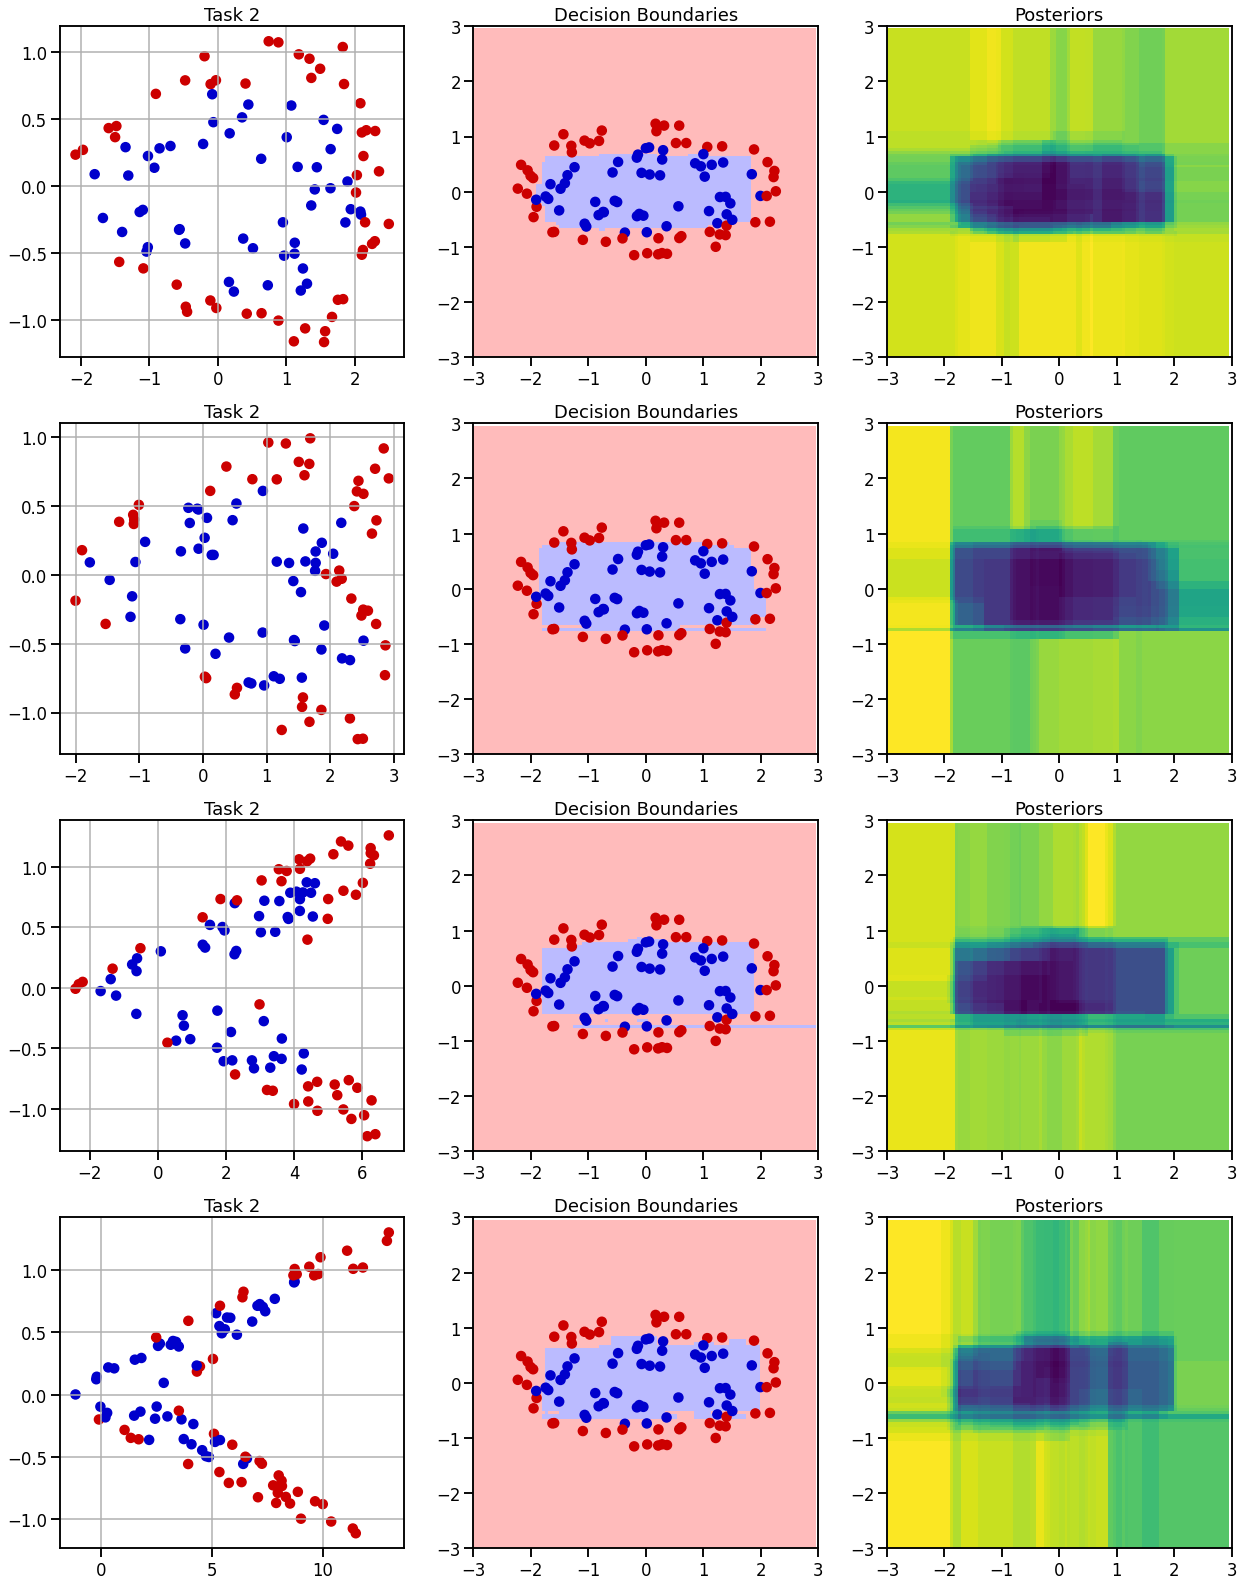

In [161]:
#Plot Decisions
l = 3;
w = 3;
n = len(S)
plt.figure(figsize=(w*7, n*7))

for i in range(n):
    #Decision Boundary
    dnl = c_nlr[i];
    dnl = dnl.reshape(xx.shape);
    
    #Posteriors
    pnl = p_nlr[i];
    pnl = pnl.reshape(xx.shape);
    
    #Task 2 Distribution
    x = x_nlr[i];
    x_orig = X[i]
    
    plt.subplot(n,w, w*i+1);
    plt.scatter(x_orig[:,0], x_orig[:,1], c=y[i], cmap=cmap_bold);
    #plt.xlim([-l,l]); plt.ylim([-l,l]);
    #plt.grid(); plt.title('NLR Adapted Task 2');  
    plt.grid(); plt.title('Task 2');
    
    #plt.subplot(n,w, w*i+2);
    #plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    #plt.xlim([-l,l]); plt.ylim([-l,l]);
    #plt.grid(); plt.title('NLR Adapted Task 2');  
    
    plt.subplot(n,w, w*i+2);
    plt.pcolormesh(xx, yy, dnl, cmap=cmap_light);
    plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Decision Boundaries');
    
    plt.subplot(n,w, w*i+3);
    plt.pcolormesh(xx, yy, pnl);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Posteriors');